In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf
import math
from celluloid import Camera


In [43]:
L = 80
T = 5

rho = 8.92
Cp = 0.092
k = 0.95

a = k/(rho*Cp) # Thermal diffusivity

lambda_sqaure = (a*math.pi**2)/L**2

n = 1 # Frequency of the sinusoidal initial conditions

In [44]:
u_x_t = lambda x, t: np.sin((x * np.pi) / L) * np.exp(-lambda_sqaure * t)

In [45]:
def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a*dy_xx

In [46]:
# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L), lambda _, on_initial: on_initial
    )

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160, num_test=2540
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.048015 s



C:\Users\sksha\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\sksha\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\sksha\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


'compile' took 0.349125 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.35e-03, 7.96e-01, 2.28e-01]    [3.56e-03, 7.96e-01, 2.28e-01]    []  
1000      [9.18e-05, 1.04e-03, 1.40e-03]    [6.90e-05, 1.04e-03, 1.40e-03]    []  
2000      [1.61e-05, 1.66e-04, 1.06e-04]    [1.28e-05, 1.66e-04, 1.06e-04]    []  
3000      [7.58e-06, 7.02e-06, 1.78e-05]    [6.30e-06, 7.02e-06, 1.78e-05]    []  
4000      [4.75e-06, 4.29e-06, 1.12e-05]    [4.16e-06, 4.29e-06, 1.12e-05]    []  
5000      [3.27e-06, 2.86e-06, 7.11e-06]    [2.94e-06, 2.86e-06, 7.11e-06]    []  
6000      [2.44e-06, 2.10e-06, 5.03e-06]    [2.20e-06, 2.10e-06, 5.03e-06]    []  
7000      [1.94e-06, 1.56e-06, 3.64e-06]    [1.74e-06, 1.56e-06, 3.64e-06]    []  
8000      [1.66e-06, 1.42e-06, 3.60e-06]    [1.47e-06, 1.42e-06, 3.60e-06]    []  
9000      [1.75e-06, 1.30e-03, 8.38e-04]    [1.38e-06, 1.30e-03, 8.38e-04]    []  
10000   

(<deepxde.model.LossHistory at 0x22b2e9f5130>,
 <deepxde.model.TrainState at 0x22b22464dc0>)

In [47]:
model.compile("L-BFGS")

Compiling model...
'compile' took 0.213653 s



In [48]:
losshistory, train_state = model.train()

Training model...

Step      Train loss                        Test loss                         Test metric
20000     [5.16e-07, 5.65e-07, 3.38e-06]    [3.90e-07, 5.65e-07, 3.38e-06]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000004
  Number of iterations: 5
  Number of functions evaluations: 25
20025     [5.16e-07, 5.91e-07, 3.35e-06]    [3.90e-07, 5.91e-07, 3.35e-06]    []  

Best model at step 11000:
  train loss: 2.57e-06
  test loss: 2.46e-06
  test metric: []

'train' took 0.515737 s



In [35]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

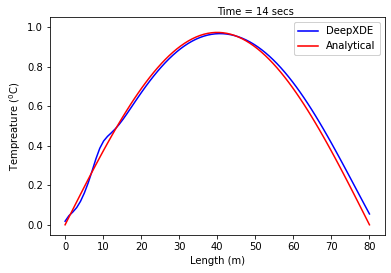

In [116]:
x = np.linspace(0, L, 80)
t = np.linspace(0, 15, 15)


xx, tt = np.meshgrid(x, t)


X = np.vstack((np.ravel(xx), np.ravel(tt))).T

final_temp = model.predict(X)

final_temps = np.split(final_temp,t.shape[0]) 
# plt.plot(x, final_temp[:x.shape[0]])
                       
# plt.show()
final_temp_ana = []

u_x_t = lambda x, t: np.sin((x * np.pi) / L) * np.exp(-lambda_sqaure * t)

fig, ax = plt.subplots()
fig.patch.set_facecolor('xkcd:white')
camera = Camera(fig)

ax.set_xlabel('Length (m)')
ax.set_ylabel('Tempreature ($^0$C)')

for i,_t in enumerate(t):


    final_temp_ana.append(u_x_t(x, _t))


    ax.plot(x, final_temps[i], '-b', x.flatten(), np.array(final_temp_ana)[i,:],'-r')

    ax.text(0.5, 1.01, "Time = {} secs ".format(int(i)), transform=ax.transAxes)

    ax.legend(['DeepXDE', 'Analytical'])

    camera.snap()


anim = camera.animate()

anim.save('solution_DeepXDE_vs_Analytical_gen.gif', dpi=100)